### Third step: PRETRAINED CONVNET
To begin, we'll use a VGG16 architecture, a simple a widely used convnet architecture for ImageNet (a dataset whit 1.4 million labeled images and 1000 diferent classes).

How to use a pretrained network?
- **feature extration**
- fine-tuning (-> in 07_Convnet_DogsVSCats_4.ipynb)

#### Feature extration
It consists of using the representations learned by a previous network to extrct interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

The fist part of a convnet is the ***convolutional base*** (the series of pooling and colvolutional layers). So feature extration for a convnet consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.

Why only the convolutional base? Because the representations learned by it are likely more generic. Note also that the level of generality depends on the depth of the layer. So if the new dataset differs a lot from the dataset on which the original model was trained, it's better to onluy use the first few layers.

Now, to the instantiating of the VGG16 convolutional base:

In [24]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                include_top = False,
                input_shape = (150, 150, 3))

- ```weights``` specifies the weight checkpoint from which to initialize the model
- ```include_top``` refers to including (or not) the densely connected classifier on top of the network
- ```input_shape``` shape of the image tensors that’ll be feed to the network (this is purely optional)

The final feature of the dat has shape (4,4,512) [```model.summary()```]. From here, there are two way:
- run the conv base over the dataset, record the output to a Numpy array on disk and then use it as the input to a densely connected classifier. Fast and cheap :). Can't use data augmentation :(
- extend the conv_base by adding Dense layers on top and run it on the input data. Can use data augmentation :). Far more expensive :(

=> **FAST FEAUTURE EXTRATION WITHOUT DATA AUGMENTATION**

In [29]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/tf/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
                directory,
                target_size=(150, 150),
                batch_size=batch_size,
                class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512) . So they need to be flatten to be fed to a densely connected classifier:

In [30]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Now the densely connected classifier (with a ```Dropout``` layer for regularization)

In [31]:
from keras import models
from keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
            loss='binary_crossentropy',
            metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    verbose=0,
                    validation_data=(validation_features, validation_labels))

#### Plotting the results

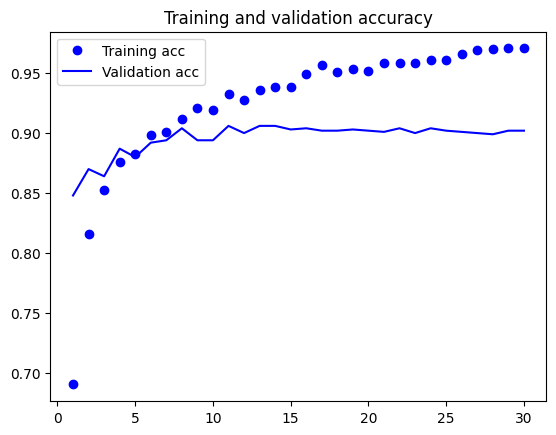

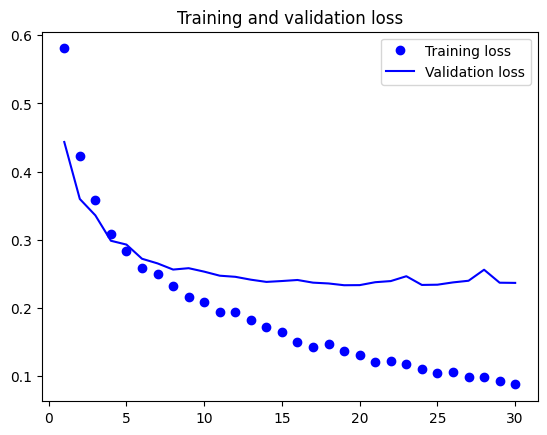

In [32]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()